In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import gpflow

from tueplots import bundles

from rtgp.rtgp import RTGPR
from rtgp.w import Shrinkage, Gaussian

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

(0.0, 20.0)

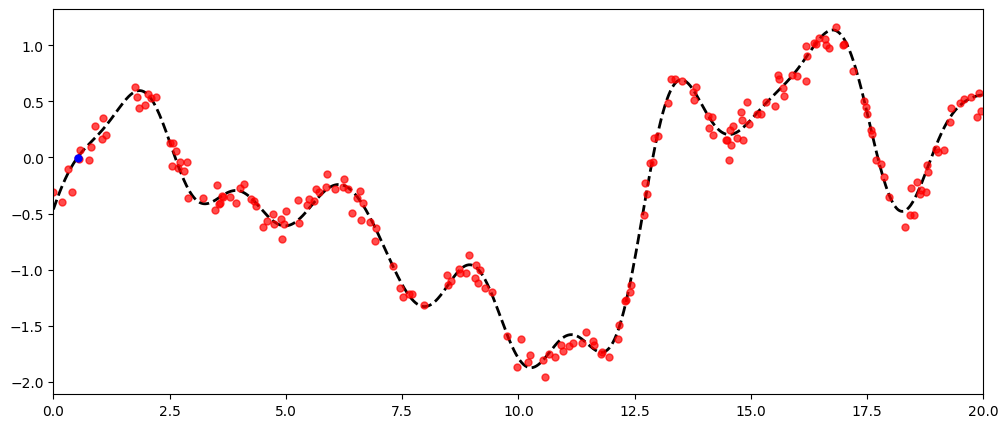

In [3]:
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

n_points = 1000
sigma_n = 0.1
percent = 0.2
percent_miss = 0.1

lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int(percent * n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=len(i_obs)).reshape(len(i_obs), 1)
x_obs = x[i_obs]
n_obs = len(y_obs)

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_min = np.argmin(np.abs(y_obs))
plt.plot(x_obs[i_min],y_obs[i_min],'b.', ms=10, zorder=10)


plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [4]:
i_min = np.argmin(np.abs(y_obs))

In [5]:
from gpflow import utilities
def standard_posterior(X, y, sigma_n = 0.1):
    gp = gpflow.models.GPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=1, variance=1),
    noise_variance=sigma_n**2
    )
    X, Y = gp.data
    n = X.shape[0]
    kmm = gp.kernel(X)
    kmm_plus_s = utilities.add_likelihood_noise_cov(kmm,gp.likelihood, X) + np.eye(n,dtype='float64')*1e-6
    Lm_plus_s = tf.linalg.cholesky(kmm_plus_s)
    A = tf.linalg.triangular_solve(Lm_plus_s, kmm, lower=True)
    B = tf.linalg.triangular_solve(Lm_plus_s, tf.linalg.set_diag(tf.eye(n,dtype='float64'),tf.squeeze(gp.likelihood.variance_at(X), axis=-1)), lower=True)
    C = tf.linalg.triangular_solve(Lm_plus_s, Y, lower=True)
    Sigma = tf.matmul(A, B, transpose_a=True)
    mu = tf.matmul(A, C, transpose_a=True)
    return mu , Sigma+ np.eye(n,dtype='float64')*1e-6


In [9]:
from rtgp.utils import add_likelihood_noise_cov

def median_absolute_deviation(Y):
    return np.median(abs(Y))

def robust_posterior(X, y, sigma_n = 0.1):
    gp = RTGPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=1, variance=1),
    diffusion_matrix = Shrinkage(C=1),
    noise_variance=sigma_n**2 
)
    X, Y = gp.data
    n = tf.shape(X)[0]
    K = gp.kernel(X)
    W = gp.diffusion_matrix.W(X, Y)
    W_dy = gp.diffusion_matrix.dy(X, Y)
    likelihood_variance = gp.likelihood.variance_at(X)
    
    K_plus_sW = add_likelihood_noise_cov(K, W, gp.likelihood, X)
    L_plus_sW = tf.linalg.cholesky(K_plus_sW + tf.eye(n, dtype='float64') * 1e-06)

    A = tf.linalg.triangular_solve(L_plus_sW, K, lower=True)
    B = tf.linalg.triangular_solve(L_plus_sW, tf.linalg.set_diag(tf.eye(n,dtype='float64'),tf.squeeze(likelihood_variance*(W**-2), axis=-1)), lower=True)


    f = y - 2*likelihood_variance*W_dy/W
    C = tf.linalg.triangular_solve(L_plus_sW, f, lower=True)


    Sigma = tf.matmul(A, B, transpose_a=True)
    mu = tf.matmul(A, C, transpose_a=True)
    return mu , Sigma+ np.eye(n,dtype='float64')*1e-6

In [10]:
epsilons = np.linspace(-10, 10, 500)

In [11]:
pif_standard = []
mu_standard, Sigma_standard = standard_posterior(x_obs, y_obs)
d1 = tfp.distributions.MultivariateNormalFullCovariance(tf.squeeze(mu_standard,axis=-1), Sigma_standard)
for epsilon in epsilons:
    x_mis = x_obs.copy()
    y_mis = y_obs.copy()
    y_mis[i_min] = y_mis[i_min] + epsilon
    mu_standard, Sigma_standard = standard_posterior(x_mis, y_mis)
    d2 = tfp.distributions.MultivariateNormalFullCovariance(tf.squeeze(mu_standard,axis=-1), Sigma_standard)
    pif_standard.append(tfp.distributions.kl_divergence(d1,d2).numpy())


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [12]:
pif_robust = []
mu_robust, Sigma_robust = robust_posterior(x_obs, y_obs)
d1 = tfp.distributions.MultivariateNormalFullCovariance(tf.squeeze(mu_robust,axis=-1), Sigma_robust)
for epsilon in epsilons:
    x_mis = x_obs.copy()
    y_mis = y_obs.copy()
    y_mis[i_min] = y_mis[i_min] + epsilon
    mu_robust, Sigma_robust = robust_posterior(x_mis, y_mis)
    d2 = tfp.distributions.MultivariateNormalFullCovariance(tf.squeeze(mu_robust,axis=-1), Sigma_robust)
    pif_robust.append(tfp.distributions.kl_divergence(d1,d2).numpy())

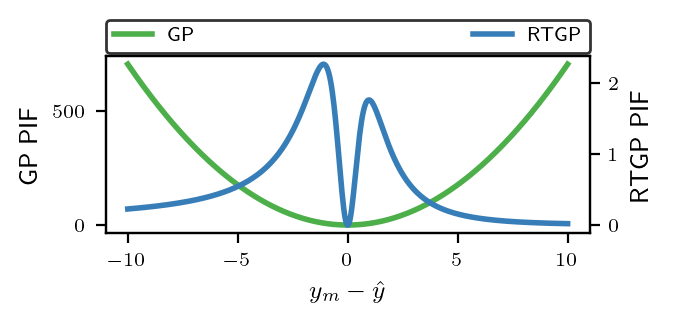

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(figsize = (3.25, 1.5), dpi = 200)
    lns1 = ax.plot(epsilons, pif_standard, c=CB_color_cycle[2], lw=2, label= 'GP')

    ax2 = ax.twinx()
    ax.set_xlabel(r"$y_{m}-\hat{y}$")
    ax.set_ylabel("GP PIF", )
    ax2.set_ylabel("RTGP PIF")


    lns2 = ax2.plot(epsilons, pif_robust, c=CB_color_cycle[0], lw=2, label= 'RTGP')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=2, edgecolor='k',fancybox=True)
    fig.savefig('pif.pdf', format="pdf", bbox_inches= "tight")